In [199]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [17]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Найти количество строк по ldn_listings

In [14]:
query = """
SELECT 
    count() AS mun
FROM ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,mun
0,85207


Найти 75% процентиль с группировкой по типу комнат

In [9]:
query_2 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM ldn_listings
LIMIT 1000
"""
df_2 = ph.read_clickhouse(query_2, connection=connection_default)
df_2

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [13]:
df_2.groupby('room_type').price.quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating)

In [49]:
query_3 = """
SELECT 
    room_type,
    toFloat32OrZero(review_scores_rating) as review,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    
FROM ldn_listings

WHERE review > 0

LIMIT 1000
"""
df_3 = ph.read_clickhouse(query_3, connection=connection_default)
df_3

,room_type,review,price
0,Private room,97.0,65.0
1,Entire home/apt,96.0,100.0
2,Entire home/apt,94.0,300.0
3,Entire home/apt,93.0,65.0
4,Private room,96.0,29.0
...,...,...,...
995,Entire home/apt,100.0,165.0
996,Private room,93.0,99.0
997,Private room,100.0,45.0
998,Private room,88.0,20.0


In [50]:
df_3_q = df_3.groupby('room_type', as_index=False).mean()

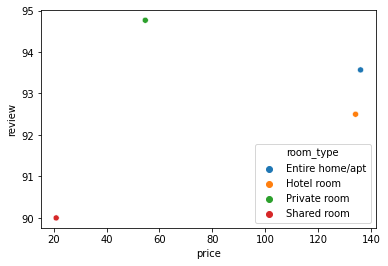

In [51]:
sns.scatterplot(data=df_3_q, y='review', x='price', hue='room_type')

Какой тип верификации у пользователей, организующих впечатления на Airbnb

In [134]:
query_4 = """
SELECT 
    DISTINCT host_id,
    host_verifications
    
FROM ldn_listings

WHERE experiences_offered != 'none'
"""
df_4 = ph.read_clickhouse(query_4, connection=connection_default)
df_4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [135]:
df_4['host_verifications'] = df_4.host_verifications.apply(lambda x: x.strip('[]') \
                                                           .replace(" ", '') \
                                                            .replace("'", '') \
                                                            .split(','))

In [125]:
df_4['host_verifications'][1]

['email', 'phone', 'reviews', 'jumio', 'government_id']

In [136]:
df_4.explode('host_verifications').host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления

In [155]:
query_5 = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    count(id) as experiences_count
    
FROM ldn_listings

WHERE experiences_offered != 'none'

GROUP BY
    neighbourhood_cleansed,
    experiences_offered

ORDER BY experiences_count DESC

LIMIT 100

"""
df_5 = ph.read_clickhouse(query_5, connection=connection_default)
df_5

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [160]:
df_5_pivot = df_5.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count').fillna(0)

In [161]:
df_5_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,0.0,0.0
Croydon,2.0,3.0,0.0,4.0
Ealing,6.0,13.0,0.0,5.0


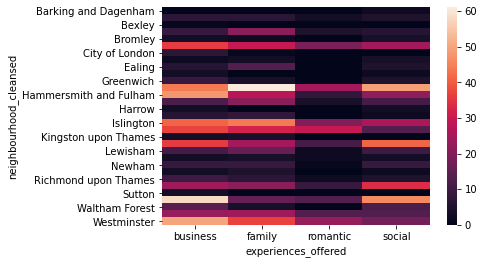

In [163]:
sns.heatmap(df_5_pivot)
cmap=sns.cubehelix_palette(as_cmap=True)

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления

In [184]:
query_6 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    
FROM ldn_listings

WHERE experiences_offered != 'none'
"""
df_6 = ph.read_clickhouse(query_6, connection=connection_default)
df_6.groupby('room_type').price.mean()

room_type
Entire home/apt    158.446854
Hotel room         112.250000
Private room        57.006527
Shared room         41.333332
Name: price, dtype: float32

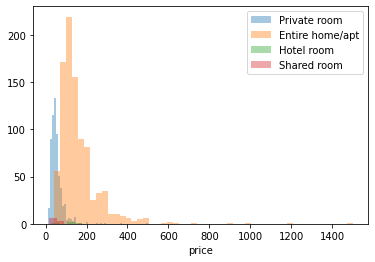

In [196]:
sns.distplot(df_6.query('room_type == "Private room"').price, kde=False, label='Private room')
sns.distplot(df_6.query('room_type == "Entire home/apt"').price, kde=False, label='Entire home/apt')
sns.distplot(df_6.query('room_type == "Hotel room"').price, kde=False, label='Hotel room')
sns.distplot(df_6.query('room_type == "Shared room"').price, kde=False, label='Shared room')
plt.legend()
plt.show()

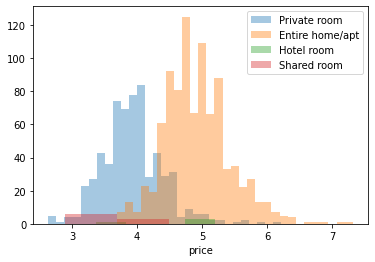

In [200]:
sns.distplot(np.log(df_6.query('room_type == "Private room"').price), kde=False, label='Private room')
sns.distplot(np.log(df_6.query('room_type == "Entire home/apt"').price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_6.query('room_type == "Hotel room"').price), kde=False, label='Hotel room')
sns.distplot(np.log(df_6.query('room_type == "Shared room"').price), kde=False, label='Shared room')
plt.legend()
plt.show()

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года

In [255]:
query_7 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review
    
FROM ldn_listings

WHERE first_review > '2010-01-01'

LIMIT 1000
"""
df_7 = ph.read_clickhouse(query_7, connection=connection_default)
df_7

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [256]:
df_7['first_review'] = df_7.first_review.apply(lambda x: x[:4])

In [257]:
df_7_group = df_7.groupby(['first_review', 'room_type'], as_index=False).agg({'price': 'mean'}).sort_values('first_review')

In [258]:
df_7_group

,first_review,room_type,price
0,2010,Entire home/apt,103.500000
1,2010,Hotel room,88.000000
2,2010,Private room,56.428570
3,2011,Entire home/apt,128.792450
4,2011,Private room,52.607143
5,2012,Entire home/apt,135.467255
6,2012,Private room,53.269840
7,2012,Shared room,22.000000
8,2013,Entire home/apt,137.887634
9,2013,Private room,57.036587


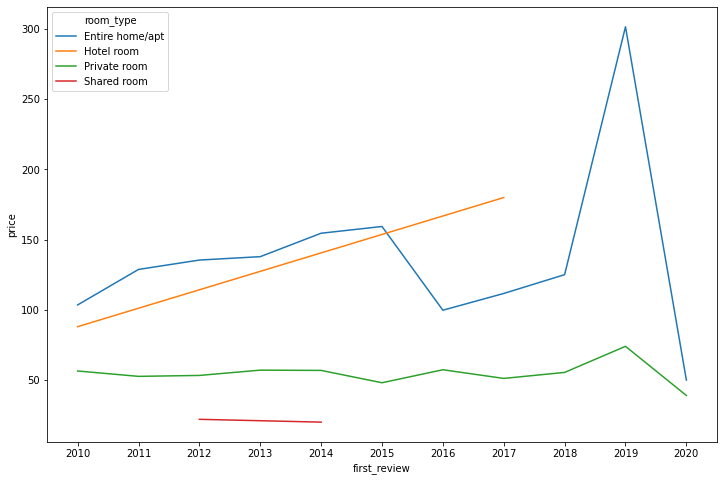

In [259]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type', data=df_7_group)